In [1]:
#Import libraries
import torch
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import zipfile
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision import transforms

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
#Upload dataset

df_training = pd.read_csv('drive/MyDrive/training.csv', sep="\t") # Put your path to training.csv here
df_test = pd.read_csv('drive/MyDrive/trial.csv', sep="\t") # Put your path to trail.csv here

In [11]:
#CNN Model

class Binary_Classifier(nn.Module):
    def __init__(self):
        super(Binary_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(58320, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#hyper parameters

learning_rate = 0.01

# Initialize Model , Optimizer, Loss

model = Binary_Classifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

In [12]:
# Due to the large input, the model is being trained in steps to avoid memory collapsing. It has been trained on the trial and training dataset.

#For the training set

steps = 10
step_training=int(df_training.shape[0]/steps)
step_test=int(df_test.shape[0]/steps)

for step in range(steps):
  input_training = []
  label_training = []
  img_zip = zipfile.ZipFile('drive/MyDrive/training.zip') # put you path to training.zip here
  img_zip.setpassword(b'*MaMiSemEval2022!')

  for i, row in tqdm(df_training.iloc[step_training*(step):step_training*(step+1)].iterrows()):
      try:
          filename = row['file_name']
          convert_tensor = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor()
      ])
          img = Image.open(img_zip.open('TRAINING/' + filename)) 
          #img = img.resize((39, 39), Image.ANTIALIAS)
          tensor=convert_tensor(img)
          if tensor.shape[0] == 3:
              input_training.append(tensor)
              label_training.append(torch.tensor(row['misogynous'],dtype=torch.long))
      except:
          print('........................')
          continue

  #For the trial set
  
  img_zip = zipfile.ZipFile('drive/MyDrive/trial.zip') # put your path to trial.zip here
  img_zip.setpassword(b'*MaMiSemEval2022!')
  for i, row in tqdm(df_test.iloc[step_test*step:step_test*(step+1)].iterrows()):
      try:
          filename = row['file_name']
          convert_tensor = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor()
      ])
          img = Image.open(img_zip.open('Users/fersiniel/Desktop/MAMI - TO LABEL/TRIAL DATASET/' + filename)) 
          #img = img.resize((39, 39), Image.ANTIALIAS)
          tensor=convert_tensor(img)
          if tensor.shape[0] == 3:
              input_training.append(tensor)
              label_training.append(torch.tensor(row['misogynous'],dtype=torch.long))
      except Exception as E:
          
          print(E)
          continue

  train_tensor = torch.stack(input_training,0).to(device=device) 
  label_tensor = torch.stack(label_training,0).to(device=device)
  del input_training, label_training
  input, input_t, label, label_t = train_test_split(train_tensor, label_tensor, test_size=0.2)
  del train_tensor, label_tensor

  
  class dataset(Dataset):
    def __init__(self,x,y):
      self.x = x
      self.y = y
      self.length = self.x.shape[0]

    def __getitem__(self,idx):
      return self.x[idx],self.y[idx]
    def __len__(self):
      return self.length
  trainset = dataset(input, label)
 
  #DataLoader
  
  trainloader = DataLoader(trainset,batch_size=32,shuffle=True)


  #forward loop
 
  losses = []
  accur = []
  epochs = 5
  acc_val=[]
  for i in tqdm(range(epochs)):
      for j,(x_train,y_train) in enumerate(trainloader):

          #calculate output
         
          output = model(x_train)

          #calculate loss
          #loss = loss_fn(output,y_train.reshape(-1,1))
          
          loss = loss_fn(output.reshape(-1,2),y_train)


          #backprop
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          #accuracy
          
          if j%10 == 0:
              with torch.no_grad():
                  losses.append(loss)
                  acc =(label == torch.argmax(model(input),dim=1)).sum()/label.size()[0]
                  acc_t = (label_t == torch.argmax(model(input_t),dim=1)).sum()/label_t.size()[0]
                  accur.append(acc)
                  acc_val.append(acc_t)
                  print(f"\nstep: {step}, epoch {i}, loss : {loss}, training accuracy : {acc}, test accuracy : {acc_t}")

1000it [00:11, 85.74it/s]
10it [00:04,  2.06it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 0, epoch 0, loss : 0.6926514506340027, training accuracy : 0.521039605140686, test accuracy : 0.5247524380683899

step: 0, epoch 0, loss : 0.8841594457626343, training accuracy : 0.4801980257034302, test accuracy : 0.47524750232696533


 20%|██        | 1/5 [00:01<00:04,  1.12s/it]


step: 0, epoch 0, loss : 0.6653885245323181, training accuracy : 0.6509900689125061, test accuracy : 0.608910858631134

step: 0, epoch 1, loss : 0.6690996289253235, training accuracy : 0.6361386179924011, test accuracy : 0.608910858631134

step: 0, epoch 1, loss : 0.610276460647583, training accuracy : 0.6262376308441162, test accuracy : 0.594059407711029


 40%|████      | 2/5 [00:02<00:02,  1.02it/s]


step: 0, epoch 1, loss : 0.6189128756523132, training accuracy : 0.719059407711029, test accuracy : 0.603960394859314

step: 0, epoch 2, loss : 0.5901327133178711, training accuracy : 0.6274752616882324, test accuracy : 0.5742574334144592

step: 0, epoch 2, loss : 0.6086480021476746, training accuracy : 0.7314356565475464, test accuracy : 0.618811845779419


 60%|██████    | 3/5 [00:02<00:01,  1.07it/s]


step: 0, epoch 2, loss : 0.5978139042854309, training accuracy : 0.7896039485931396, test accuracy : 0.6584158539772034

step: 0, epoch 3, loss : 0.3334207832813263, training accuracy : 0.8254950642585754, test accuracy : 0.6336633563041687

step: 0, epoch 3, loss : 0.4506107568740845, training accuracy : 0.7623762488365173, test accuracy : 0.6534653306007385


 80%|████████  | 4/5 [00:03<00:00,  1.09it/s]


step: 0, epoch 3, loss : 0.40048664808273315, training accuracy : 0.905940592288971, test accuracy : 0.5792078971862793

step: 0, epoch 4, loss : 0.3555939495563507, training accuracy : 0.9146039485931396, test accuracy : 0.5742574334144592

step: 0, epoch 4, loss : 0.4601652920246124, training accuracy : 0.8910890817642212, test accuracy : 0.514851450920105


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]



step: 0, epoch 4, loss : 0.2792607545852661, training accuracy : 0.8910890817642212, test accuracy : 0.5742574334144592


1000it [00:09, 105.27it/s]
10it [00:03,  2.89it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 1, epoch 0, loss : 0.7712947726249695, training accuracy : 0.6290322542190552, test accuracy : 0.6633663177490234

step: 1, epoch 0, loss : 0.6473492980003357, training accuracy : 0.6997518539428711, test accuracy : 0.6336633563041687


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]


step: 1, epoch 0, loss : 0.719696581363678, training accuracy : 0.7506203651428223, test accuracy : 0.6138613820075989

step: 1, epoch 1, loss : 0.46081486344337463, training accuracy : 0.7320099472999573, test accuracy : 0.6534653306007385

step: 1, epoch 1, loss : 0.43352267146110535, training accuracy : 0.8163771629333496, test accuracy : 0.6287128329277039


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]


step: 1, epoch 1, loss : 0.5079813599586487, training accuracy : 0.8548387289047241, test accuracy : 0.6782178282737732

step: 1, epoch 2, loss : 0.4350307881832123, training accuracy : 0.8709677457809448, test accuracy : 0.6782178282737732

step: 1, epoch 2, loss : 0.35801371932029724, training accuracy : 0.8982630372047424, test accuracy : 0.6534653306007385


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]


step: 1, epoch 2, loss : 0.3297092914581299, training accuracy : 0.9305210709571838, test accuracy : 0.6287128329277039

step: 1, epoch 3, loss : 0.22539645433425903, training accuracy : 0.9429280161857605, test accuracy : 0.6386138796806335

step: 1, epoch 3, loss : 0.34494879841804504, training accuracy : 0.9540942907333374, test accuracy : 0.6584158539772034


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]


step: 1, epoch 3, loss : 0.14432188868522644, training accuracy : 0.9739453792572021, test accuracy : 0.6287128329277039

step: 1, epoch 4, loss : 0.10308319330215454, training accuracy : 0.9727047085762024, test accuracy : 0.6485148668289185

step: 1, epoch 4, loss : 0.1306219846010208, training accuracy : 0.9863523244857788, test accuracy : 0.603960394859314


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]



step: 1, epoch 4, loss : 0.08297401666641235, training accuracy : 0.981389582157135, test accuracy : 0.6435643434524536


1000it [00:10, 95.86it/s]
10it [00:02,  4.20it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 2, epoch 0, loss : 0.8287212252616882, training accuracy : 0.606965184211731, test accuracy : 0.606965184211731

step: 2, epoch 0, loss : 0.8961070775985718, training accuracy : 0.7014925479888916, test accuracy : 0.6368159055709839


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]


step: 2, epoch 0, loss : 0.6380597949028015, training accuracy : 0.6691542267799377, test accuracy : 0.6517412662506104

step: 2, epoch 1, loss : 0.551551878452301, training accuracy : 0.7139303088188171, test accuracy : 0.6666666269302368

step: 2, epoch 1, loss : 0.5291976928710938, training accuracy : 0.7723880410194397, test accuracy : 0.6815920472145081


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]


step: 2, epoch 1, loss : 0.5408046841621399, training accuracy : 0.7997512221336365, test accuracy : 0.6567164063453674

step: 2, epoch 2, loss : 0.3694736957550049, training accuracy : 0.7711442708969116, test accuracy : 0.6368159055709839

step: 2, epoch 2, loss : 0.4557366669178009, training accuracy : 0.8482586741447449, test accuracy : 0.6666666269302368


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]


step: 2, epoch 2, loss : 0.40007737278938293, training accuracy : 0.9017412662506104, test accuracy : 0.6517412662506104

step: 2, epoch 3, loss : 0.28973865509033203, training accuracy : 0.922885537147522, test accuracy : 0.641791045665741

step: 2, epoch 3, loss : 0.2610310912132263, training accuracy : 0.9502487182617188, test accuracy : 0.6517412662506104


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]


step: 2, epoch 3, loss : 0.2048882395029068, training accuracy : 0.9390547275543213, test accuracy : 0.6815920472145081

step: 2, epoch 4, loss : 0.24469567835330963, training accuracy : 0.9129353165626526, test accuracy : 0.5970149040222168

step: 2, epoch 4, loss : 0.24720893800258636, training accuracy : 0.9751243591308594, test accuracy : 0.6467661261558533


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



step: 2, epoch 4, loss : 0.08399218320846558, training accuracy : 0.9776118993759155, test accuracy : 0.6368159055709839


1000it [00:10, 98.20it/s]
10it [00:02,  4.10it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 3, epoch 0, loss : 1.0390839576721191, training accuracy : 0.6225247383117676, test accuracy : 0.5841584205627441

step: 3, epoch 0, loss : 0.7406087517738342, training accuracy : 0.712871253490448, test accuracy : 0.5891088843345642


 20%|██        | 1/5 [00:00<00:03,  1.28it/s]


step: 3, epoch 0, loss : 0.5026613473892212, training accuracy : 0.771039605140686, test accuracy : 0.6534653306007385

step: 3, epoch 1, loss : 0.5301253199577332, training accuracy : 0.7846534252166748, test accuracy : 0.5643564462661743

step: 3, epoch 1, loss : 0.5142826437950134, training accuracy : 0.8007425665855408, test accuracy : 0.5841584205627441


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]


step: 3, epoch 1, loss : 0.33226850628852844, training accuracy : 0.858910858631134, test accuracy : 0.6336633563041687

step: 3, epoch 2, loss : 0.5169719457626343, training accuracy : 0.8910890817642212, test accuracy : 0.6287128329277039

step: 3, epoch 2, loss : 0.2559210956096649, training accuracy : 0.9183168411254883, test accuracy : 0.603960394859314


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]


step: 3, epoch 2, loss : 0.35554447770118713, training accuracy : 0.9356435537338257, test accuracy : 0.618811845779419

step: 3, epoch 3, loss : 0.20516209304332733, training accuracy : 0.9579207897186279, test accuracy : 0.594059407711029

step: 3, epoch 3, loss : 0.10308203101158142, training accuracy : 0.9641088843345642, test accuracy : 0.6287128329277039


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]


step: 3, epoch 3, loss : 0.1810949593782425, training accuracy : 0.9764851331710815, test accuracy : 0.5792078971862793

step: 3, epoch 4, loss : 0.16078586876392365, training accuracy : 0.9702970385551453, test accuracy : 0.5891088843345642

step: 3, epoch 4, loss : 0.07484381645917892, training accuracy : 0.9863861203193665, test accuracy : 0.5990098714828491


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



step: 3, epoch 4, loss : 0.08777505904436111, training accuracy : 0.9975247383117676, test accuracy : 0.5990098714828491


1000it [00:10, 91.54it/s]
10it [00:02,  3.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 4, epoch 0, loss : 1.6196202039718628, training accuracy : 0.582608699798584, test accuracy : 0.5544554591178894

step: 4, epoch 0, loss : 0.6668112874031067, training accuracy : 0.662111759185791, test accuracy : 0.5544554591178894


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]


step: 4, epoch 0, loss : 0.6294069886207581, training accuracy : 0.6409937739372253, test accuracy : 0.5495049357414246

step: 4, epoch 1, loss : 0.6289740204811096, training accuracy : 0.6844720244407654, test accuracy : 0.5495049357414246

step: 4, epoch 1, loss : 0.5319830775260925, training accuracy : 0.7689440846443176, test accuracy : 0.5544554591178894


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]


step: 4, epoch 1, loss : 0.4572959542274475, training accuracy : 0.8322980999946594, test accuracy : 0.5346534848213196

step: 4, epoch 2, loss : 0.45205432176589966, training accuracy : 0.8459627032279968, test accuracy : 0.5297029614448547

step: 4, epoch 2, loss : 0.34144270420074463, training accuracy : 0.8745341300964355, test accuracy : 0.5247524380683899


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]


step: 4, epoch 2, loss : 0.31397417187690735, training accuracy : 0.9254658222198486, test accuracy : 0.5247524380683899

step: 4, epoch 3, loss : 0.14181625843048096, training accuracy : 0.9366459250450134, test accuracy : 0.5247524380683899

step: 4, epoch 3, loss : 0.2141212821006775, training accuracy : 0.9552794694900513, test accuracy : 0.5396039485931396


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]


step: 4, epoch 3, loss : 0.19770309329032898, training accuracy : 0.9739130139350891, test accuracy : 0.5544554591178894

step: 4, epoch 4, loss : 0.09716778993606567, training accuracy : 0.98385089635849, test accuracy : 0.5594059228897095

step: 4, epoch 4, loss : 0.061793550848960876, training accuracy : 0.9863353967666626, test accuracy : 0.5693069100379944


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]



step: 4, epoch 4, loss : 0.16928306221961975, training accuracy : 0.9900621175765991, test accuracy : 0.5544554591178894


1000it [00:09, 105.95it/s]
10it [00:02,  3.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 5, epoch 0, loss : 1.6310347318649292, training accuracy : 0.5632754564285278, test accuracy : 0.5594059228897095

step: 5, epoch 0, loss : 0.8557531833648682, training accuracy : 0.6153846383094788, test accuracy : 0.5198019742965698


 20%|██        | 1/5 [00:00<00:03,  1.28it/s]


step: 5, epoch 0, loss : 0.6483020186424255, training accuracy : 0.6972704529762268, test accuracy : 0.5643564462661743

step: 5, epoch 1, loss : 0.6199117302894592, training accuracy : 0.7394540905952454, test accuracy : 0.5693069100379944

step: 5, epoch 1, loss : 0.5325444936752319, training accuracy : 0.826302707195282, test accuracy : 0.594059407711029


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]


step: 5, epoch 1, loss : 0.5526155233383179, training accuracy : 0.8610422015190125, test accuracy : 0.5693069100379944

step: 5, epoch 2, loss : 0.44869476556777954, training accuracy : 0.8895781636238098, test accuracy : 0.6138613820075989

step: 5, epoch 2, loss : 0.38537755608558655, training accuracy : 0.9081885814666748, test accuracy : 0.608910858631134


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]


step: 5, epoch 2, loss : 0.370879203081131, training accuracy : 0.9478908181190491, test accuracy : 0.5742574334144592

step: 5, epoch 3, loss : 0.20691917836666107, training accuracy : 0.9478908181190491, test accuracy : 0.608910858631134

step: 5, epoch 3, loss : 0.19012440741062164, training accuracy : 0.9466500878334045, test accuracy : 0.5495049357414246


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]


step: 5, epoch 3, loss : 0.23123344779014587, training accuracy : 0.9751861095428467, test accuracy : 0.6287128329277039

step: 5, epoch 4, loss : 0.08822731673717499, training accuracy : 0.9863523244857788, test accuracy : 0.6237623691558838

step: 5, epoch 4, loss : 0.039039287716150284, training accuracy : 0.9826302528381348, test accuracy : 0.6138613820075989


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



step: 5, epoch 4, loss : 0.11496381461620331, training accuracy : 0.9900744557380676, test accuracy : 0.5792078971862793


1000it [00:10, 91.24it/s]
10it [00:02,  4.48it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 6, epoch 0, loss : 0.9678224921226501, training accuracy : 0.5873606204986572, test accuracy : 0.6584158539772034

step: 6, epoch 0, loss : 0.8091996908187866, training accuracy : 0.6765799522399902, test accuracy : 0.5891088843345642


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]


step: 6, epoch 0, loss : 0.6607193350791931, training accuracy : 0.7583643198013306, test accuracy : 0.6534653306007385

step: 6, epoch 1, loss : 0.5622081756591797, training accuracy : 0.8104089498519897, test accuracy : 0.6534653306007385

step: 6, epoch 1, loss : 0.425468772649765, training accuracy : 0.8661710023880005, test accuracy : 0.6485148668289185


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]


step: 6, epoch 1, loss : 0.489128053188324, training accuracy : 0.9169764518737793, test accuracy : 0.6683168411254883

step: 6, epoch 2, loss : 0.25857922434806824, training accuracy : 0.938042163848877, test accuracy : 0.6683168411254883

step: 6, epoch 2, loss : 0.2519437372684479, training accuracy : 0.9479554295539856, test accuracy : 0.6435643434524536


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]


step: 6, epoch 2, loss : 0.31396448612213135, training accuracy : 0.9702602624893188, test accuracy : 0.6138613820075989

step: 6, epoch 3, loss : 0.12365489453077316, training accuracy : 0.9764560461044312, test accuracy : 0.6485148668289185

step: 6, epoch 3, loss : 0.09642590582370758, training accuracy : 0.9851301312446594, test accuracy : 0.6287128329277039


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]


step: 6, epoch 3, loss : 0.17111772298812866, training accuracy : 0.9814126491546631, test accuracy : 0.5891088843345642

step: 6, epoch 4, loss : 0.10152815282344818, training accuracy : 0.9913259148597717, test accuracy : 0.6138613820075989

step: 6, epoch 4, loss : 0.020245468243956566, training accuracy : 0.9888476133346558, test accuracy : 0.6336633563041687


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]



step: 6, epoch 4, loss : 0.1864299178123474, training accuracy : 0.9913259148597717, test accuracy : 0.6435643434524536


1000it [00:13, 73.49it/s]
10it [00:02,  4.06it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 7, epoch 0, loss : 0.8500432372093201, training accuracy : 0.5792078971862793, test accuracy : 0.594059407711029

step: 7, epoch 0, loss : 0.8958759903907776, training accuracy : 0.6633663177490234, test accuracy : 0.5841584205627441


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]


step: 7, epoch 0, loss : 0.7082865238189697, training accuracy : 0.7660890817642212, test accuracy : 0.5990098714828491

step: 7, epoch 1, loss : 0.4757677912712097, training accuracy : 0.8452970385551453, test accuracy : 0.5990098714828491

step: 7, epoch 1, loss : 0.4462222754955292, training accuracy : 0.8836633563041687, test accuracy : 0.5742574334144592


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]


step: 7, epoch 1, loss : 0.3287660777568817, training accuracy : 0.9306930303573608, test accuracy : 0.5693069100379944

step: 7, epoch 2, loss : 0.21523195505142212, training accuracy : 0.9517326354980469, test accuracy : 0.5891088843345642

step: 7, epoch 2, loss : 0.2038876712322235, training accuracy : 0.9603960514068604, test accuracy : 0.5643564462661743


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]


step: 7, epoch 2, loss : 0.1666523516178131, training accuracy : 0.983910858631134, test accuracy : 0.5643564462661743

step: 7, epoch 3, loss : 0.18386462330818176, training accuracy : 0.9814356565475464, test accuracy : 0.5693069100379944

step: 7, epoch 3, loss : 0.09533017873764038, training accuracy : 0.9851484894752502, test accuracy : 0.5891088843345642


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]


step: 7, epoch 3, loss : 0.13799862563610077, training accuracy : 0.9913366436958313, test accuracy : 0.5594059228897095

step: 7, epoch 4, loss : 0.02016475610435009, training accuracy : 0.9975247383117676, test accuracy : 0.5742574334144592

step: 7, epoch 4, loss : 0.03475828841328621, training accuracy : 1.0, test accuracy : 0.5594059228897095


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



step: 7, epoch 4, loss : 0.043745994567871094, training accuracy : 0.9975247383117676, test accuracy : 0.5594059228897095


1000it [00:10, 98.25it/s]
10it [00:02,  3.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 8, epoch 0, loss : 1.1336966753005981, training accuracy : 0.5853960514068604, test accuracy : 0.6633663177490234

step: 8, epoch 0, loss : 0.8263741135597229, training accuracy : 0.7153465151786804, test accuracy : 0.6336633563041687


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]


step: 8, epoch 0, loss : 0.6850358247756958, training accuracy : 0.7883663177490234, test accuracy : 0.6435643434524536

step: 8, epoch 1, loss : 0.5658539533615112, training accuracy : 0.780940592288971, test accuracy : 0.608910858631134

step: 8, epoch 1, loss : 0.43617886304855347, training accuracy : 0.8849009871482849, test accuracy : 0.6633663177490234


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]


step: 8, epoch 1, loss : 0.3421081304550171, training accuracy : 0.9232673048973083, test accuracy : 0.6534653306007385

step: 8, epoch 2, loss : 0.18129685521125793, training accuracy : 0.9529702663421631, test accuracy : 0.618811845779419

step: 8, epoch 2, loss : 0.16601896286010742, training accuracy : 0.9616336226463318, test accuracy : 0.6584158539772034


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]


step: 8, epoch 2, loss : 0.17929044365882874, training accuracy : 0.9764851331710815, test accuracy : 0.6633663177490234

step: 8, epoch 3, loss : 0.08449623733758926, training accuracy : 0.9900990128517151, test accuracy : 0.6386138796806335

step: 8, epoch 3, loss : 0.06517555564641953, training accuracy : 0.9900990128517151, test accuracy : 0.6782178282737732


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]


step: 8, epoch 3, loss : 0.037924788892269135, training accuracy : 0.9925742149353027, test accuracy : 0.6386138796806335

step: 8, epoch 4, loss : 0.02891339361667633, training accuracy : 0.9987623691558838, test accuracy : 0.6435643434524536

step: 8, epoch 4, loss : 0.03654035925865173, training accuracy : 0.9975247383117676, test accuracy : 0.6287128329277039


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]



step: 8, epoch 4, loss : 0.09061099588871002, training accuracy : 0.9925742149353027, test accuracy : 0.6732673048973083


1000it [00:09, 105.25it/s]
10it [00:02,  4.44it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


step: 9, epoch 0, loss : 1.0474523305892944, training accuracy : 0.5848823189735413, test accuracy : 0.603960394859314

step: 9, epoch 0, loss : 0.5853137969970703, training accuracy : 0.729863703250885, test accuracy : 0.5445544719696045


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]


step: 9, epoch 0, loss : 0.5527871251106262, training accuracy : 0.8500619530677795, test accuracy : 0.5891088843345642

step: 9, epoch 1, loss : 0.3990243971347809, training accuracy : 0.8921933174133301, test accuracy : 0.5643564462661743

step: 9, epoch 1, loss : 0.3489915728569031, training accuracy : 0.938042163848877, test accuracy : 0.594059407711029


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]


step: 9, epoch 1, loss : 0.27936187386512756, training accuracy : 0.9776951670646667, test accuracy : 0.5693069100379944

step: 9, epoch 2, loss : 0.1395372897386551, training accuracy : 0.9863693118095398, test accuracy : 0.5643564462661743

step: 9, epoch 2, loss : 0.07204487174749374, training accuracy : 0.9863693118095398, test accuracy : 0.5891088843345642


 60%|██████    | 3/5 [00:02<00:01,  1.16it/s]


step: 9, epoch 2, loss : 0.14858964085578918, training accuracy : 0.9987608790397644, test accuracy : 0.5841584205627441

step: 9, epoch 3, loss : 0.03426000475883484, training accuracy : 0.997521698474884, test accuracy : 0.5891088843345642

step: 9, epoch 3, loss : 0.03056998737156391, training accuracy : 0.9962825775146484, test accuracy : 0.5693069100379944


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]


step: 9, epoch 3, loss : 0.03206696733832359, training accuracy : 0.9987608790397644, test accuracy : 0.5891088843345642

step: 9, epoch 4, loss : 0.008630191907286644, training accuracy : 1.0, test accuracy : 0.5693069100379944

step: 9, epoch 4, loss : 0.0074251797050237656, training accuracy : 0.9987608790397644, test accuracy : 0.5445544719696045


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


step: 9, epoch 4, loss : 0.01673254370689392, training accuracy : 1.0, test accuracy : 0.5841584205627441


# Test

In [13]:
#Upoad and read test data
img_zip = zipfile.ZipFile('drive/MyDrive/test.zip') # put your path to test.zip here
img_zip.setpassword(b'*MaMiSemEval2022!')
df_test = pd.read_csv('drive/MyDrive/test_labels.txt', delimiter="\t", header=None) # put your path to test_labels.txt here

In [16]:
#Pre-processing test data
input = []
label = []

for i, row in tqdm(df_test.iterrows()):
    try:
        filename = row['file_name']
        convert_tensor = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

         
        
        img = Image.open(img_zip.open('test/' + filename)) 
        
        tensor=convert_tensor(img)
        if tensor.shape[0] == 3:
            input.append(tensor)
            label.append(torch.tensor(row['misogynous'],dtype=torch.long))
    except Exception as e:
        print(e)
        continue

1000it [04:08,  4.02it/s]


In [17]:
test_tensor = torch.stack(input,0).to(device=device) 
test_label_tensor = torch.stack(label,0).to(device=device)

In [18]:
output = torch.argmax(model(test_tensor),dim=1)

In [19]:
output.shape

torch.Size([1000])

In [20]:
#Create a pickle file of the predicted labels of the cnn to be used for the fusion

arrayInput = output #Trial input
fileName = "cnn_output.pkl"
fileObject = open(fileName, 'wb')
pkl.dump(arrayInput, fileObject)
fileObject.close()

TypeError: ignored

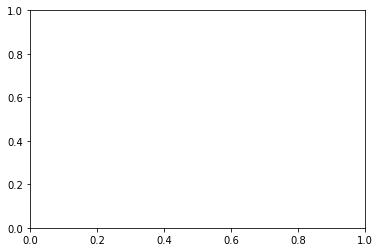

In [23]:
plt.plot(acc_val)
plt.title('Test Accuracy History')
plt.ylabel('Accuracy')
plt.xlabel('10.steps')
plt.show()

TypeError: ignored

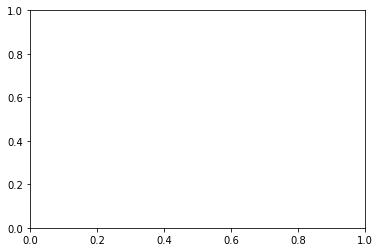

In [22]:
plt.plot(losses)
plt.title('Loss History')
plt.ylabel('Loss')
plt.xlabel('10.steps')
plt.show()